In [1]:
import cv2 as cv
import keras
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random as rd

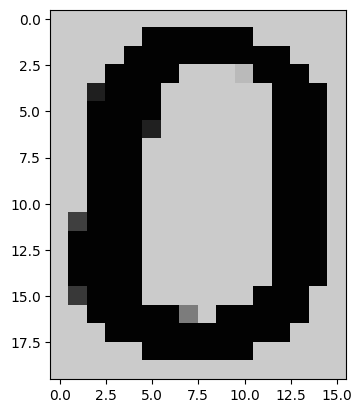

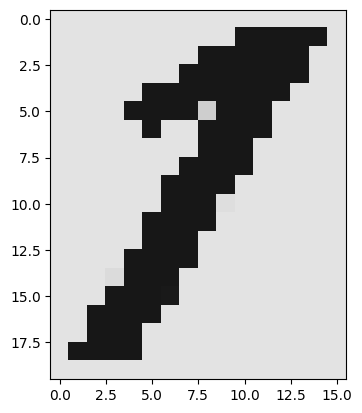

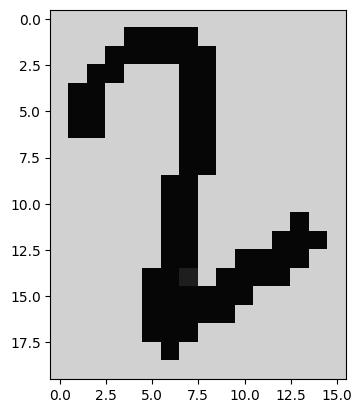

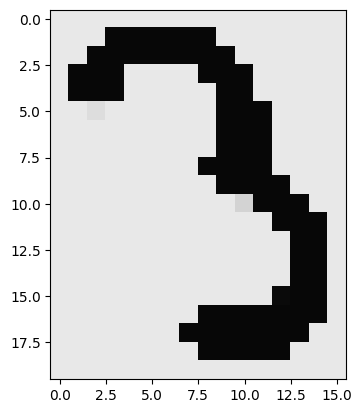

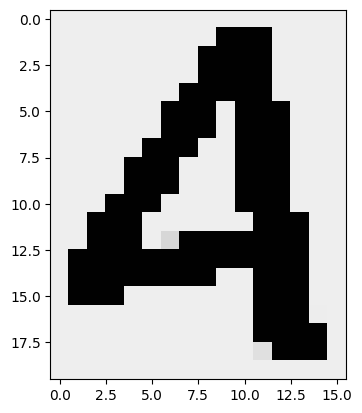

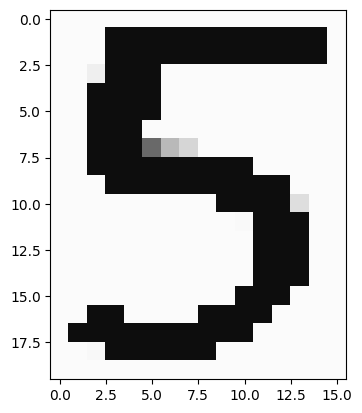

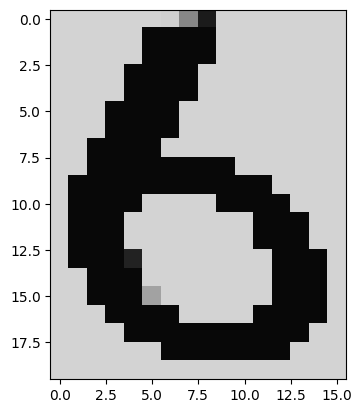

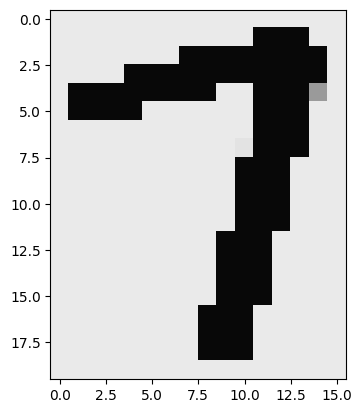

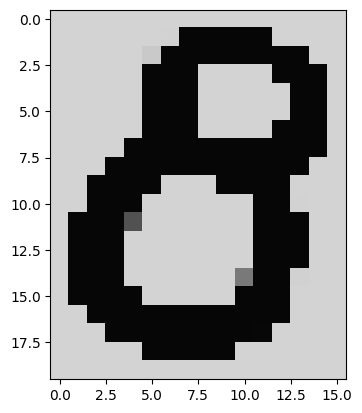

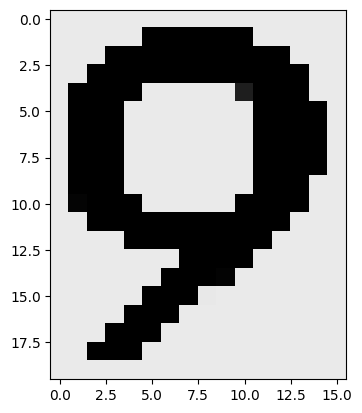

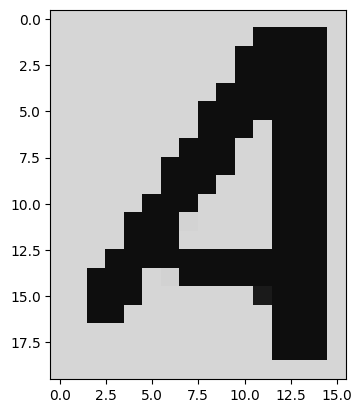

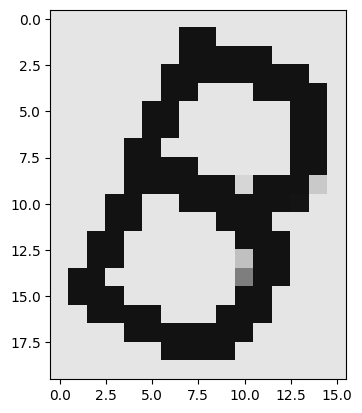

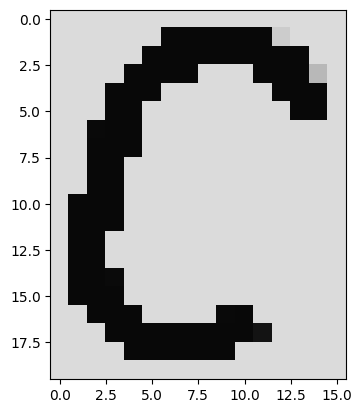

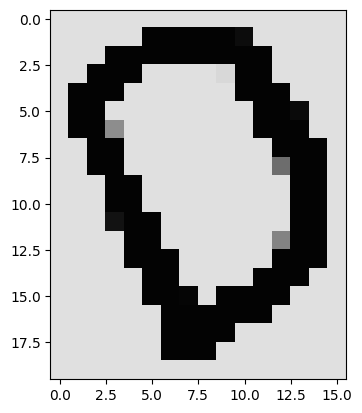

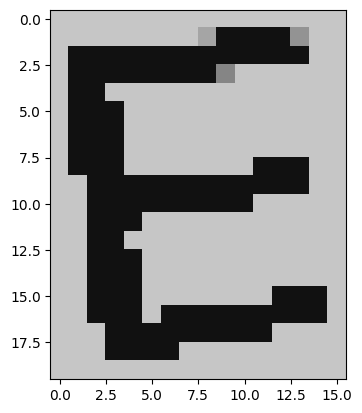

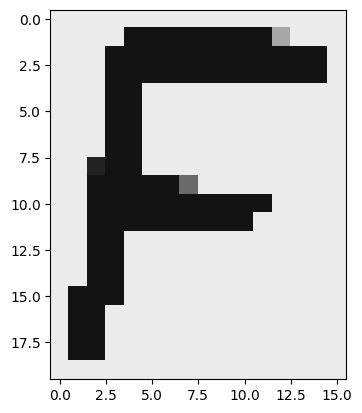

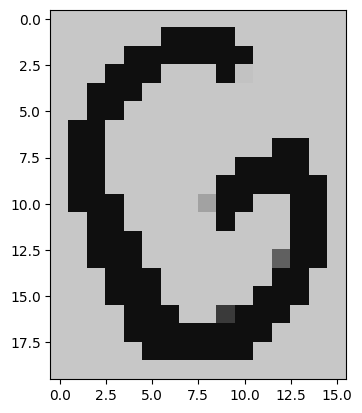

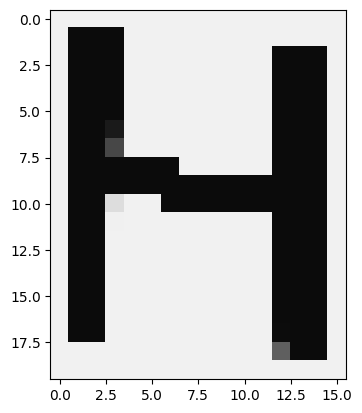

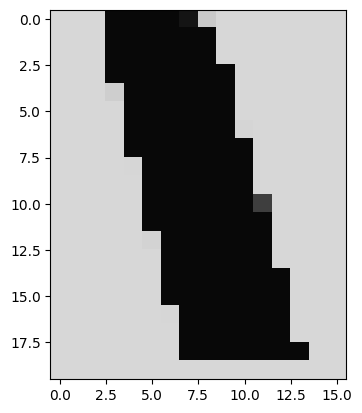

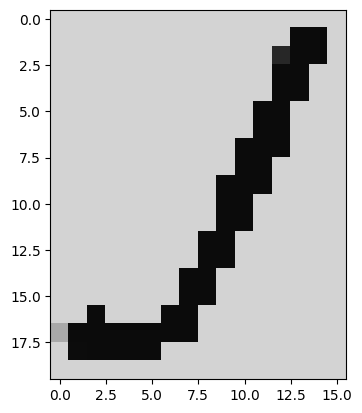

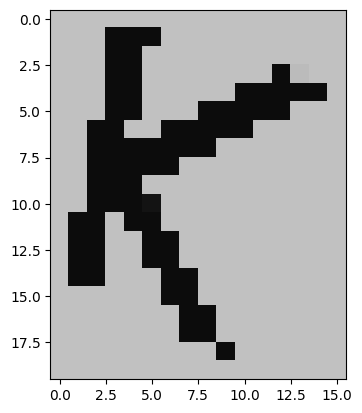

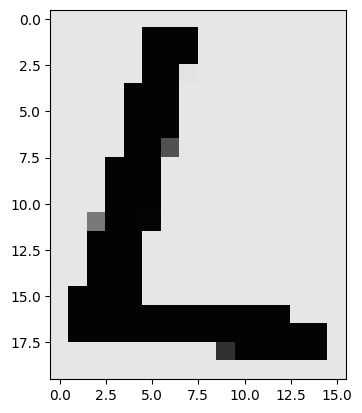

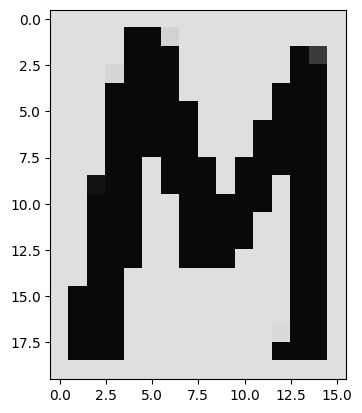

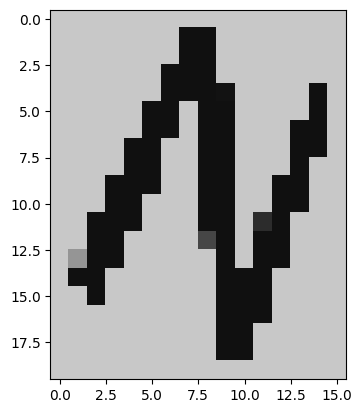

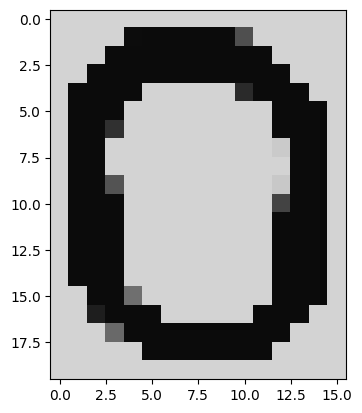

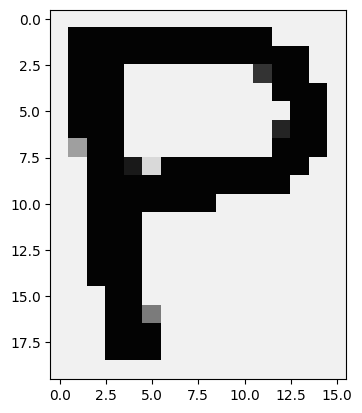

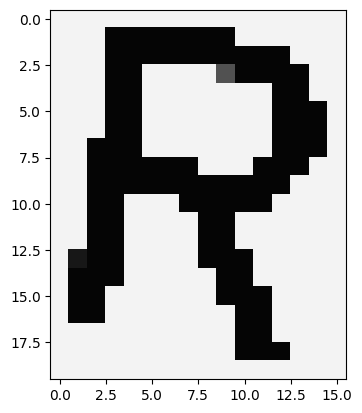

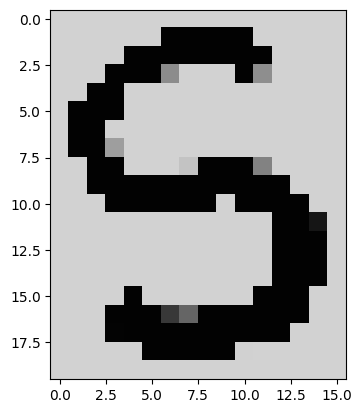

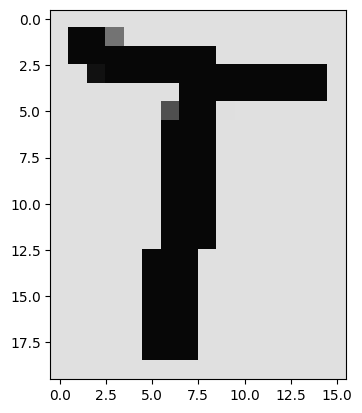

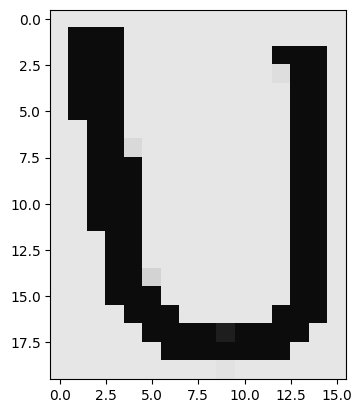

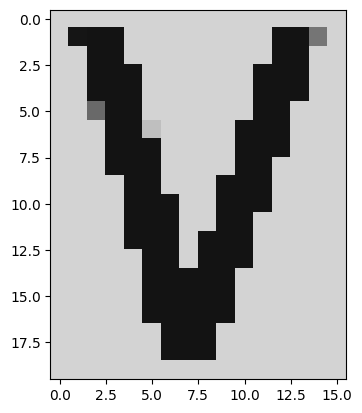

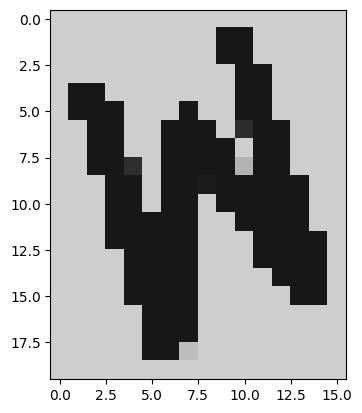

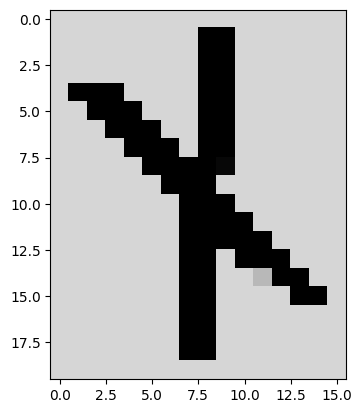

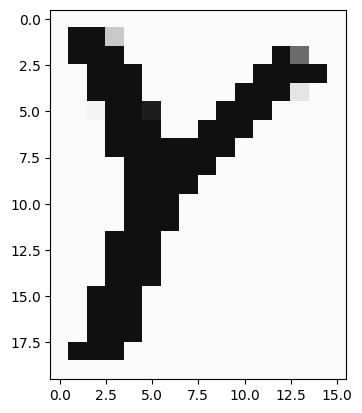

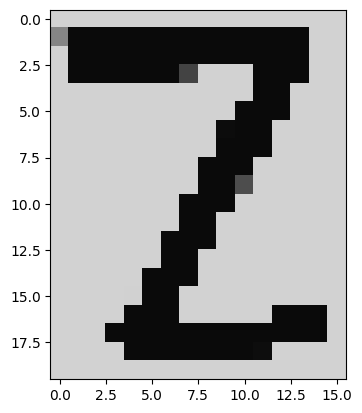

In [10]:
rd.seed(None)
dataset_dir = 'dataset'
background_dirt = 0.25 # 1 = czarne tło
foreground_dirt = 0.1 # 1 = białe napisy
edge_padding = 20 # px
warp_factor = 0.3
rotation_range = 60 # deg
cut_step = 30 # px
out_edge_padding = 0 # px
trim_before_warp = False
# out_size = (28,40)
# out_size = (28,28)
# out_size = (24,32)
# out_size = (16,24)
out_size = (16,20)
# out_size = (16,16)

for file in os.listdir(dataset_dir):
    img_orig = cv.imread(os.path.join(dataset_dir, file), cv.IMREAD_UNCHANGED)
    
    # create background, make grayscale, apply dirt
    bgcol = 1 - background_dirt * rd.random()
    fgcol = foreground_dirt * rd.random()
    img = np.ones((img_orig.shape[0],img_orig.shape[1])) * bgcol
    img[img_orig[:,:,3] != 0] = fgcol
    img = np.pad(img, edge_padding, constant_values=bgcol)
    
    # rotate by img center
    while True:
        pad_x = (int(np.sum(np.square(img.shape))**(1/2)-img.shape[0])//2,)*2
        pad_y = (int(np.sum(np.square(img.shape))**(1/2)-img.shape[1])//2,)*2
        img = np.pad(img, (pad_x, pad_y), constant_values=bgcol)
        matrix = cv.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), (rd.random()-0.5)*rotation_range, 1)
        rotated = cv.warpAffine(img, matrix, (img.shape[1],img.shape[0]), borderValue=bgcol)
        # check borders intersecting with character, rotation valid if none
        if all(rotated[:,0]!=fgcol) and all(rotated[:,-1]!=fgcol) and all(rotated[0,:]!=fgcol) and all(rotated[-1,:]!=fgcol):
            break
    
    img = rotated
    
    if trim_before_warp:
        # trim additional whitespaces
        while not any(img[:,2*cut_step]==fgcol):
            img = img[:,cut_step:]
        while not any(img[:,-2*cut_step]==fgcol):
            img = img[:,:-cut_step]
        while not any(img[2*cut_step,:]==fgcol):
            img = img[cut_step:,:]
        while not any(img[-2*cut_step,:]==fgcol):
            img = img[:-cut_step,:]
    
    # warp
    while True:
        # get proportional warp ranges
        offset_x, offset_y = int(img.shape[0] * warp_factor), int(img.shape[1] * warp_factor)
        points_start = np.float32([[0,0], [img.shape[1], 0], [0, img.shape[0]], [img.shape[1],img.shape[0]]])
        warped = np.pad(img, ((offset_x,offset_x),(offset_y,offset_y)), constant_values=bgcol)
        points_start[:,0] += offset_x 
        points_start[:,1] += offset_y
        points_end = np.copy(points_start)
        points_end[:,0] = [i + (rd.random()-0.5) * offset_y for i in points_end[:,0]]
        points_end[:,1] = [i + (rd.random()-0.5) * offset_x for i in points_end[:,1]]
        matrix = cv.getPerspectiveTransform(points_start, points_end)
        result_shape = (warped.shape[1],warped.shape[0])
        warped = cv.warpPerspective(img, matrix, result_shape, borderValue=bgcol)
        # check borders intersecting with character, warp valid if none
        if all(warped[:,0]!=fgcol) and all(warped[:,-1]!=fgcol) and all(warped[0,:]!=fgcol) and all(warped[-1,:]!=fgcol):
            break
    img = warped
    
    # trim additional whitespaces
    while not any(img[:,2*cut_step]==fgcol):
        img = img[:,cut_step:]
    while not any(img[:,-2*cut_step]==fgcol):
        img = img[:,:-cut_step]
    while not any(img[2*cut_step,:]==fgcol):
        img = img[cut_step:,:]
    while not any(img[-2*cut_step,:]==fgcol):
        img = img[:-cut_step,:]
    
    img = np.pad(img, out_edge_padding, constant_values=bgcol)
    
    img = cv.resize(img, out_size)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.show()


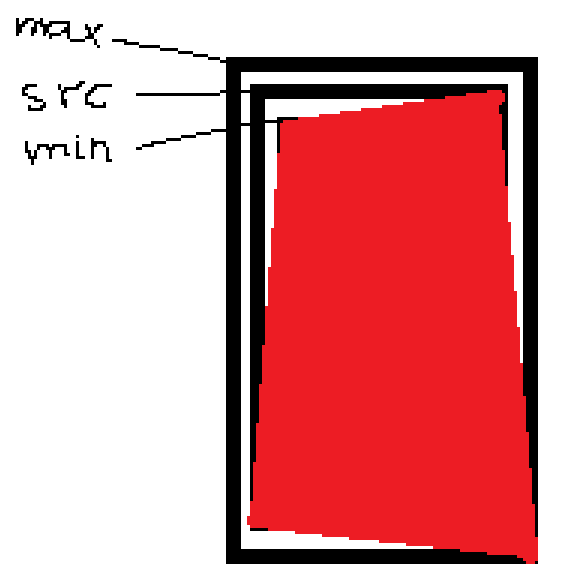
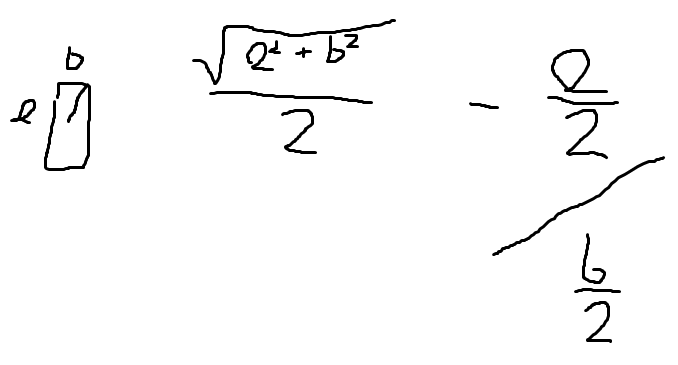

In [ ]:
min_len, max_len = 5, 7
